# <span style="color:red"> Logistic Regression - Top Prediction Analysis </span>

## dropping 'A Wild Sheep Chase'
* read in pickle v02
* keep 3 translators
* try different feature sets and save model each time
* compare results at the end
* all features available ie normalised counts and pos counts with some drops plus unique words, adj, adv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import label_binarize

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# extend limit of number of rows and columns to display in cell
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100


Bad key "text.kerning_factor" on line 4 in
/Users/Steven/opt/anaconda3/envs/textacy/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


### Load the dataframe containing text chunks and related variables

In [2]:
in_full_path = '../../../Documents/murakami/pkl3/df_all_v02.pkl'
# read back pickle
with open (in_full_path, 'rb') as fp:
    df = pickle.load(fp)

### Check the dataframe is as expected

In [3]:
df.head(1)

,book_chunk_no,number,title,text,fstop_indices,split_indices,chunks,translator,book_title,parsed,n_sents,n_words,n_chars,n_syllables,n_unique_words,n_long_words,n_monosyllable_words,n_polysyllable_words,trans_code,chunk_length,n_sents_norm,n_words_norm,n_chars_norm,n_syllables_norm,n_unique_words_norm,n_long_words_norm,n_monosyllable_words_norm,n_polysyllable_words_norm,vader_compound,vader_neg,vader_neu,vader_pos,pron_count,verb_count,det_count,adj_count,num_count,punct_count,noun_count,adp_count,cconj_count,sconj_count,adv_count,aux_count,part_count,propn_count,space_count,intj_count,sym_count,x_count,...,where_adv,too_adv,now_adv,all_adv,then_adv,just_adv,really_adv,there_adv,only_adv,even_adv,as_adv,always_adv,when_adv,again_adv,here_adv,maybe_adv,still_adv,back_adv,why_adv,very_adv,never_adv,how_adv,whole_adj,small_adj,long_adj,able_adj,more_adj,sure_adj,big_adj,last_adj,bad_adj,old_adj,same_adj,good_adj,new_adj,only_adj,different_adj,other_adj,next_adj,few_adj,much_adj,hard_adj,real_adj,young_adj,own_adj,first_adj,deep_adj,strange_adj,little_adj,right_adj
0,0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",IT WAS A short one-paragraph item in the morni...,Alfred Birnbaum,A Wild Sheep Chase,"(IT, WAS, A, short, one, -, paragraph, item, i...",15,174,742,240,116,33,128,17,0,944,15.889831,184.322034,786.016949,254.237288,122.881356,34.957627,135.59322,18.008475,-0.4798,0.075,0.862,0.064,18.0,20.0,31.0,9.0,2.0,33.0,51.0,19.0,6.0,3.0,5.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(5253, 141)

In [5]:
df.book_title.unique()

array(['A Wild Sheep Chase', 'Kafka On The Shore',
       'Colorless Tsukuru Tazaki', 'The Elephant Vanishes',
       'The Wind Up Bird Chronicle', 'Norwegian Wood',
       'Dance Dance Dance'], dtype=object)

In [6]:
df = df[df['book_title'] != 'A Wild Sheep Chase']

In [7]:
df.book_title.unique()

array(['Kafka On The Shore', 'Colorless Tsukuru Tazaki',
       'The Elephant Vanishes', 'The Wind Up Bird Chronicle',
       'Norwegian Wood', 'Dance Dance Dance'], dtype=object)

In [8]:
df.columns

Index(['book_chunk_no', 'number', 'title', 'text', 'fstop_indices',
       'split_indices', 'chunks', 'translator', 'book_title', 'parsed',
       ...
       'much_adj', 'hard_adj', 'real_adj', 'young_adj', 'own_adj', 'first_adj',
       'deep_adj', 'strange_adj', 'little_adj', 'right_adj'],
      dtype='object', length=141)

### Check the baseline

In [9]:
baseline_acc = df['trans_code'].value_counts(normalize=True).max()
baseline_acc

0.4364282726892514

### Set initial Predictor Variables
* Choose normalised count variables from textacy, ntlk dropping some suspicious ones
* not using vader sentiment scores

### Choose features to include in modelling

In [10]:
def feature_select(basic_counts=True, vader=False, pos_counts=False, 
                   words=False, adv=False, adj=False):
    '''create column list depending on features to include in the modelling'''
    columns = []
    if basic_counts:
        columns += [i for i in df.columns if i.startswith('n_') & i.endswith('_norm')]
    if vader:
        columns += [i for i in df.columns if i.startswith('vader_')]
    if pos_counts:
        columns += [i for i in df.columns if i.endswith('_count_norm')]
    if words:
        columns += [i for i in df.columns if i.endswith('_w')]
    if adj:
        columns += [i for i in df.columns if i.endswith('_adj')]
    if adv:
        columns += [i for i in df.columns if i.endswith('_adv')]
    return columns

### Drop some columns which may be linked to page formatting

In [11]:
cols_to_drop = ['num_count_norm', 'punct_count_norm','space_count_norm', 'sym_count_norm', 'x_count_norm']

## Run a best logistic regression

In [13]:
predictor_cols = feature_select(basic_counts=True, pos_counts=True, vader=False, words=True, adj=True, adv=True)
predictor_cols = [x for x in predictor_cols if x not in cols_to_drop]

X = df[predictor_cols]
y = df['trans_code']

indices = list(df.index)

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

lreg_final = LogisticRegression(C=1, penalty='l1', solver='liblinear', multi_class='ovr', max_iter=1000)

lreg_final.fit(X_train, y_train)
predictions = lreg_final.predict(X_test)
lreg_final.score(X_test, y_test)

0.7084639498432602

In [14]:
# code could be useful for refactoring some of the code abobe - extracting from tuples/dicts etc to df
# df_pred = pd.DataFrame([(x.r_ui, x.est) for x in predictions_full],
#                        columns=['Rating', 'Predicted'])

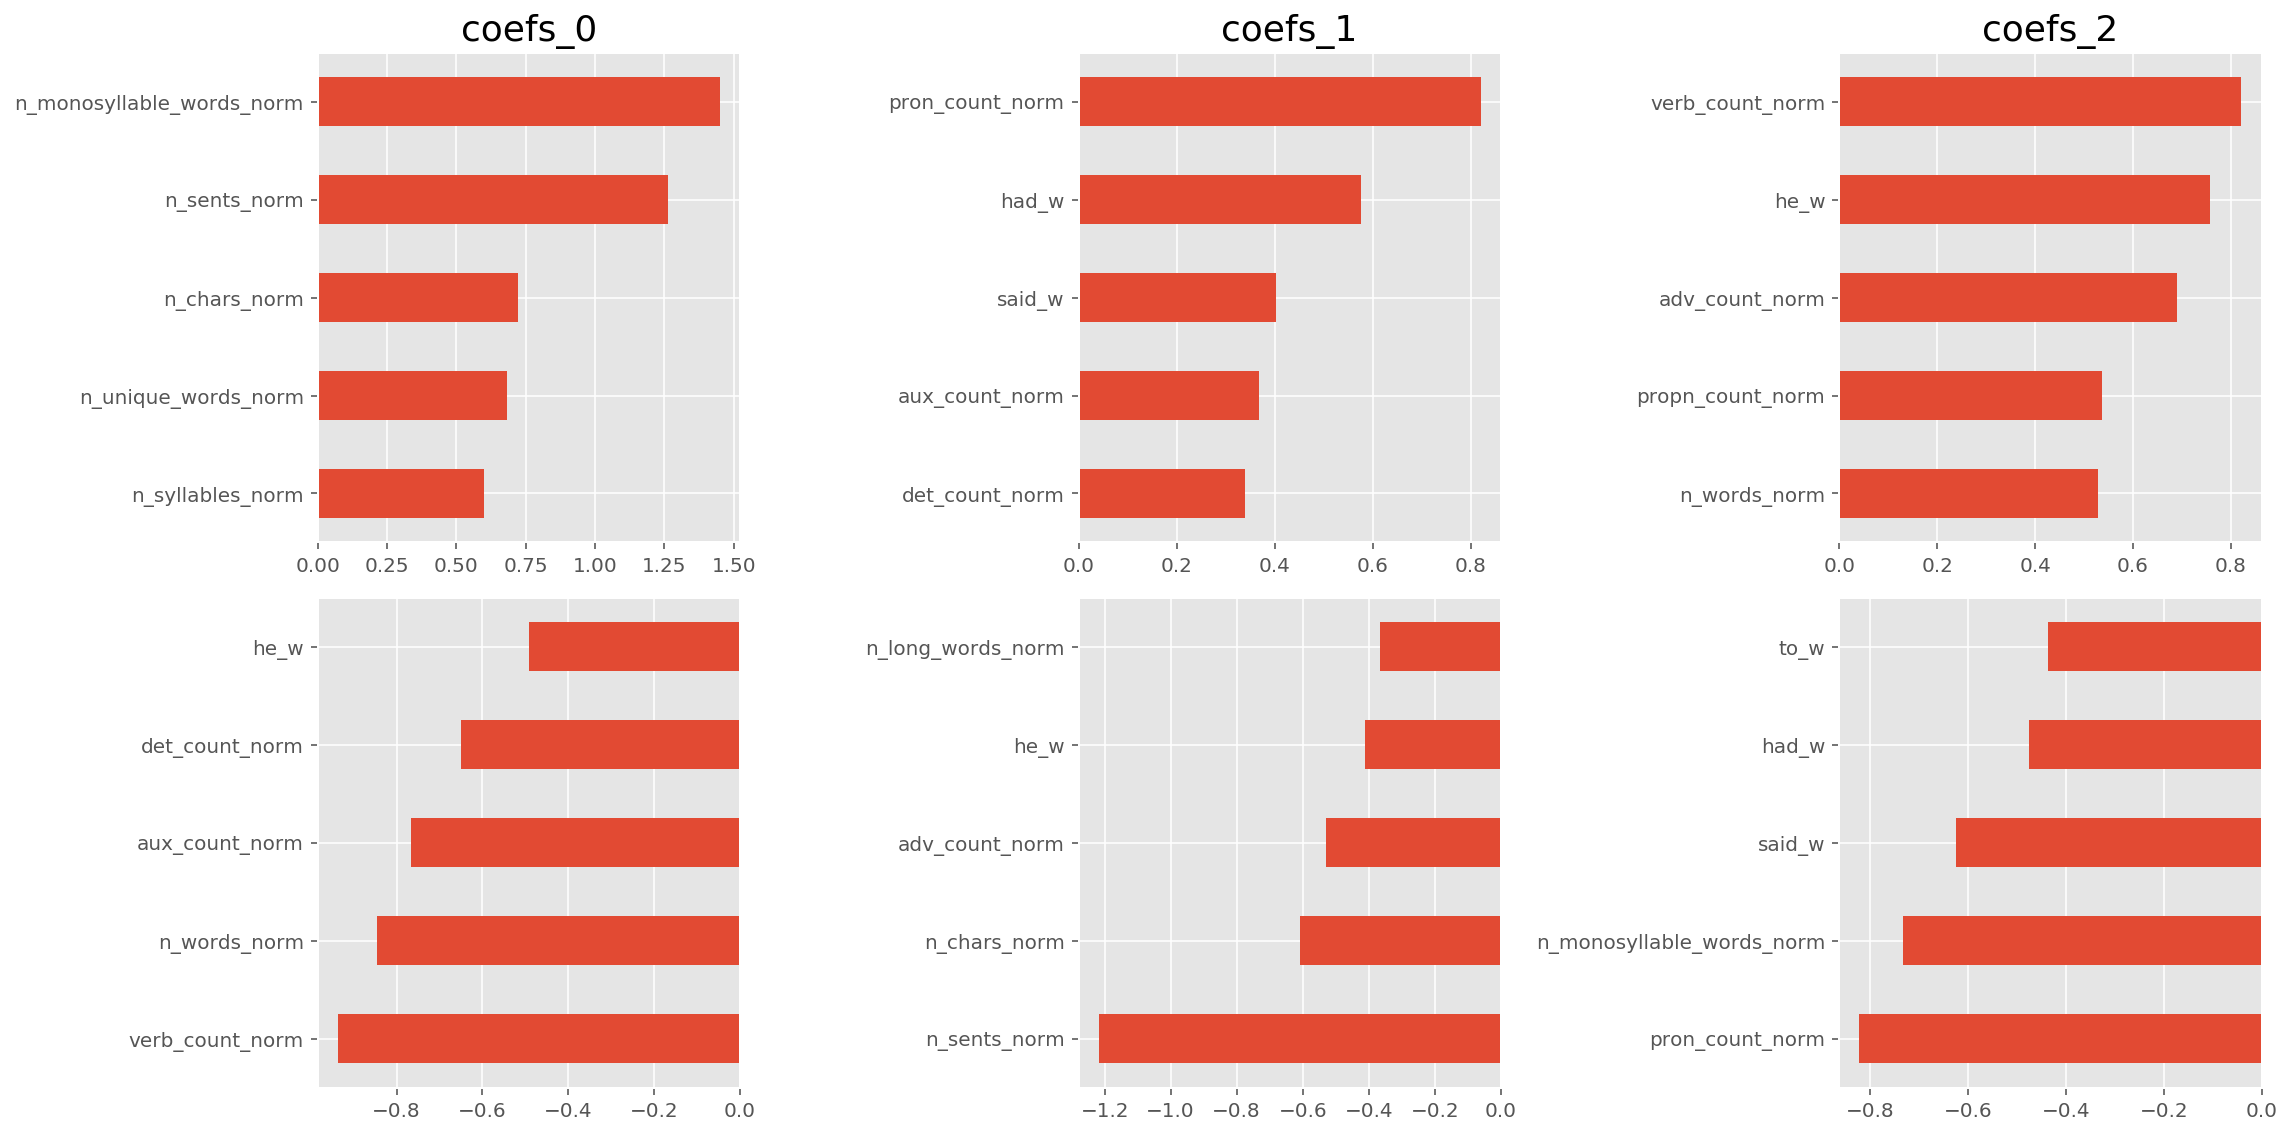

In [17]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(lreg_final.coef_, columns=predictor_cols,
                       index=['coefs_0', 'coefs_1', 'coefs_2']).T

fig, ax = plt.subplots(nrows=2, ncols=len(df_coef.columns), figsize=(16, 8))
for i, col in enumerate(df_coef.columns):
    df_coef[col].sort_values(ascending=True).tail(5).plot(kind='barh', ax=ax[0,i])
    ax[0,i].set_title(str(col), fontsize=18)
    df_coef[col].sort_values(ascending=True).head(5).plot(kind='barh', ax=ax[1,i])
plt.tight_layout()
plt.show()

## Review most confidently predicted texts per translator

In [18]:
# Get the predicted probabilities and explicitly name the columns:
Y_pp = pd.DataFrame(lreg_final.predict_proba(X_test), 
             columns=['trans_0_pp', 'trans_1_pp', 'trans_2_pp'])
# add the original indices from before the train test shuffle
Y_pp['original_index'] = idx_test
Y_pp.head()

,trans_0_pp,trans_1_pp,trans_2_pp,original_index
0,0.318644,0.360410,0.320946,1524
1,0.078598,0.167070,0.754332,2738
2,0.167167,0.671321,0.161512,3546
3,0.196502,0.241707,0.561791,2698
4,0.126303,0.797831,0.075866,3386


In [19]:
Y_pp_merged = Y_pp.merge(df, how='left', left_on='original_index', right_index=True)

In [20]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_0_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
385,0.940110,0.038263,0.021627,"No matter how out of focus the picture, I had...",Alfred Birnbaum,Dance Dance Dance,163,13
43,0.900266,0.043974,0.055761,Then Hatsumi once again said she knew a girl s...,Alfred Birnbaum,Norwegian Wood,118,8
557,0.897961,0.021631,0.080408,"He looked it over, folded it in quarters, and ...",Alfred Birnbaum,The Elephant Vanishes,379,10
834,0.896920,0.058023,0.045057,I’d probably have to bring it into the garage ...,Alfred Birnbaum,The Elephant Vanishes,251,7
710,0.893618,0.084320,0.022062,“I don’t disappear so easily. I’m not going a...,Alfred Birnbaum,Dance Dance Dance,625,43


In [21]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_1_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
489,0.000253,0.994690,0.005057,"I looked around, and I examined myself, and I...",Jay Rubin,The Wind Up Bird Chronicle,637,14
603,0.004227,0.985726,0.010047,His first victim was the man who had been the...,Jay Rubin,The Wind Up Bird Chronicle,1148,32
163,0.012455,0.983190,0.004355,"I listened, making suitable responses. I heard...",Jay Rubin,The Wind Up Bird Chronicle,88,4
660,0.006454,0.983070,0.010476,"When I had finished speaking, a deep silence ...",Jay Rubin,The Wind Up Bird Chronicle,1205,34
110,0.008147,0.978196,0.013658,I should eat the top box straight away because...,Jay Rubin,Norwegian Wood,592,2


In [22]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title', 'book_chunk_no', 'number']] \
                                  .sort_values('trans_2_pp', ascending=False).head(5)

,trans_0_pp,trans_1_pp,trans_2_pp,chunks,translator,book_title,book_chunk_no,number
928,0.021528,0.033281,0.945191,He tried to open his eyes but couldn’t. He jus...,Philip Gabriel,Kafka On The Shore,480,24
702,0.016377,0.044811,0.938813,He had no idea what people coming to buy a Le...,Philip Gabriel,Colorless Tsukuru Tazaki,197,10
587,0.020065,0.049903,0.930032,"So I get lost, and can’t buy tickets, either.""...",Philip Gabriel,Kafka On The Shore,419,22
565,0.044860,0.038782,0.916358,"He got a simple train schedule, sat down on a...",Philip Gabriel,Colorless Tsukuru Tazaki,446,19
306,0.050240,0.053415,0.896345,At eight-thirty they went out to the rental c...,Philip Gabriel,Kafka On The Shore,716,38


## Most confident for translator 0: 
* better now without 'A wild sheep chase' with the strange dialogue!

In [23]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_0_pp', ascending=False).iloc[0,3]

' No matter how out of focus the picture, I had to unravel each strand patiently. Unravel, then bind all together. I had to recover my world. But where to begin? Not a clue. I was flat against a high wall. Everything was mirror-slick. No place for the hand, no place to reach out and grab. I was at wit’s end. I paid my bill and left. Big flakes of snow tumbled down from the sky. It wasn’t really coming down yet, but the sound of the town was different because of the snow. I walked briskly around the block to sober up. Where to begin? Where to go? I didn’t know. I was rusting, badly. Alone like this, I would gradually render myself useless. Great, just great. Where to begin? My receptionist friend? She seemed nice. I did like her. I did feel a bond between us. I could sleep with her if I tried. But then what? Where would I go from there? Nowhere, probably. Just another thing to lose. I don’t know what I want . And, if that’s the case, as my ex-wife said, I’d only hurt people.'

In [53]:
# Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
#                                   .sort_values('trans_0_pp', ascending=False).iloc[1,3]

In [54]:
# Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
#                                   .sort_values('trans_0_pp', ascending=False).iloc[2,3]

## Most confident for translator 1

In [26]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_1_pp', ascending=False).iloc[0,3]

' I looked around, and I examined myself, and I realized that I had become a new person, quite different from what I had been until then. This was my third self. My first self had been the one that lived in the endless anguish of pain. My second self had been the one that lived in a state of pain-free numbness. The first one had been me in my original state, unable to shift the heavy yoke of pain from my neck. And when I did attempt to shift it – which is to say, when I tried to kill myself and failed – I became my second self: an interim me. True, the physical pain that had tortured me until then had disappeared, but all other sensations had retreated with it into the haze. My will to live, my physical vitality, my mental powers of concentration: all these had disappeared along with the pain. After I passed through that strange period of transition, what emerged was a brand-new me. Whether this was the me that should have been there all along I could not yet tell.'

In [55]:
# Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
#                                   .sort_values('trans_1_pp', ascending=False).iloc[1,3]

In [56]:
# Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
#                                   .sort_values('trans_1_pp', ascending=False).iloc[2,3]

## Most confident for translator 2

In [30]:
Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
                                  .sort_values('trans_2_pp', ascending=False).iloc[0,3]

'He tried to open his eyes but couldn’t. He just lay there, helpless, facedown on the tatami, drooling, tears streaming down his face. He must have endured this for some thirty seconds or so. Finally he was able to breathe again, and he staggered as he sat up. The tatami wavered before him like the sea in a storm. "I’m sure it was painful." Hoshino shook his head a few times, as if checking to see that he was still alive. "Pain doesn’t begin to describe it. Imagine getting skinned alive, skewered, ground down, then run over by an angry herd of bulls. What the hell did you do to me?" "I put your bones back in the right position. You should be fine for the time being.Your back won’t ache. And I guarantee you’ll take good dumps." As predicted, when the pain receded, like the tide going out, his back did feel better. The usual heavy, sluggish feeling had vanished. The area around his temples felt much better, and he could breathe more easily. And sure enough, he felt like going to the john

In [57]:
# Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
#                                   .sort_values('trans_2_pp', ascending=False).iloc[1,3]

In [58]:
# Y_pp_merged[['trans_0_pp', 'trans_1_pp', 'trans_2_pp', 'chunks', 'translator', 'book_title']] \
#                                   .sort_values('trans_2_pp', ascending=False).iloc[2,3]

## Look at key predictor values for most confident results

In [68]:
# top_g = Y_pp_merged.sort_values('trans_2_pp', ascending=False).head(1)
print(Y_pp_merged.sort_values('trans_0_pp', ascending=False).head(1).index)
print(Y_pp_merged.sort_values('trans_1_pp', ascending=False).head(1).index)
print(Y_pp_merged.sort_values('trans_2_pp', ascending=False).head(1).index)
top_b

Int64Index([385], dtype='int64')
Int64Index([489], dtype='int64')
Int64Index([928], dtype='int64')


Int64Index([385], dtype='int64')

In [36]:
top_predictions = Y_pp_merged[Y_pp_merged.index.isin([385,489,928])]

In [37]:
df.columns

Index(['book_chunk_no', 'number', 'title', 'text', 'fstop_indices',
       'split_indices', 'chunks', 'translator', 'book_title', 'parsed',
       ...
       'much_adj', 'hard_adj', 'real_adj', 'young_adj', 'own_adj', 'first_adj',
       'deep_adj', 'strange_adj', 'little_adj', 'right_adj'],
      dtype='object', length=141)

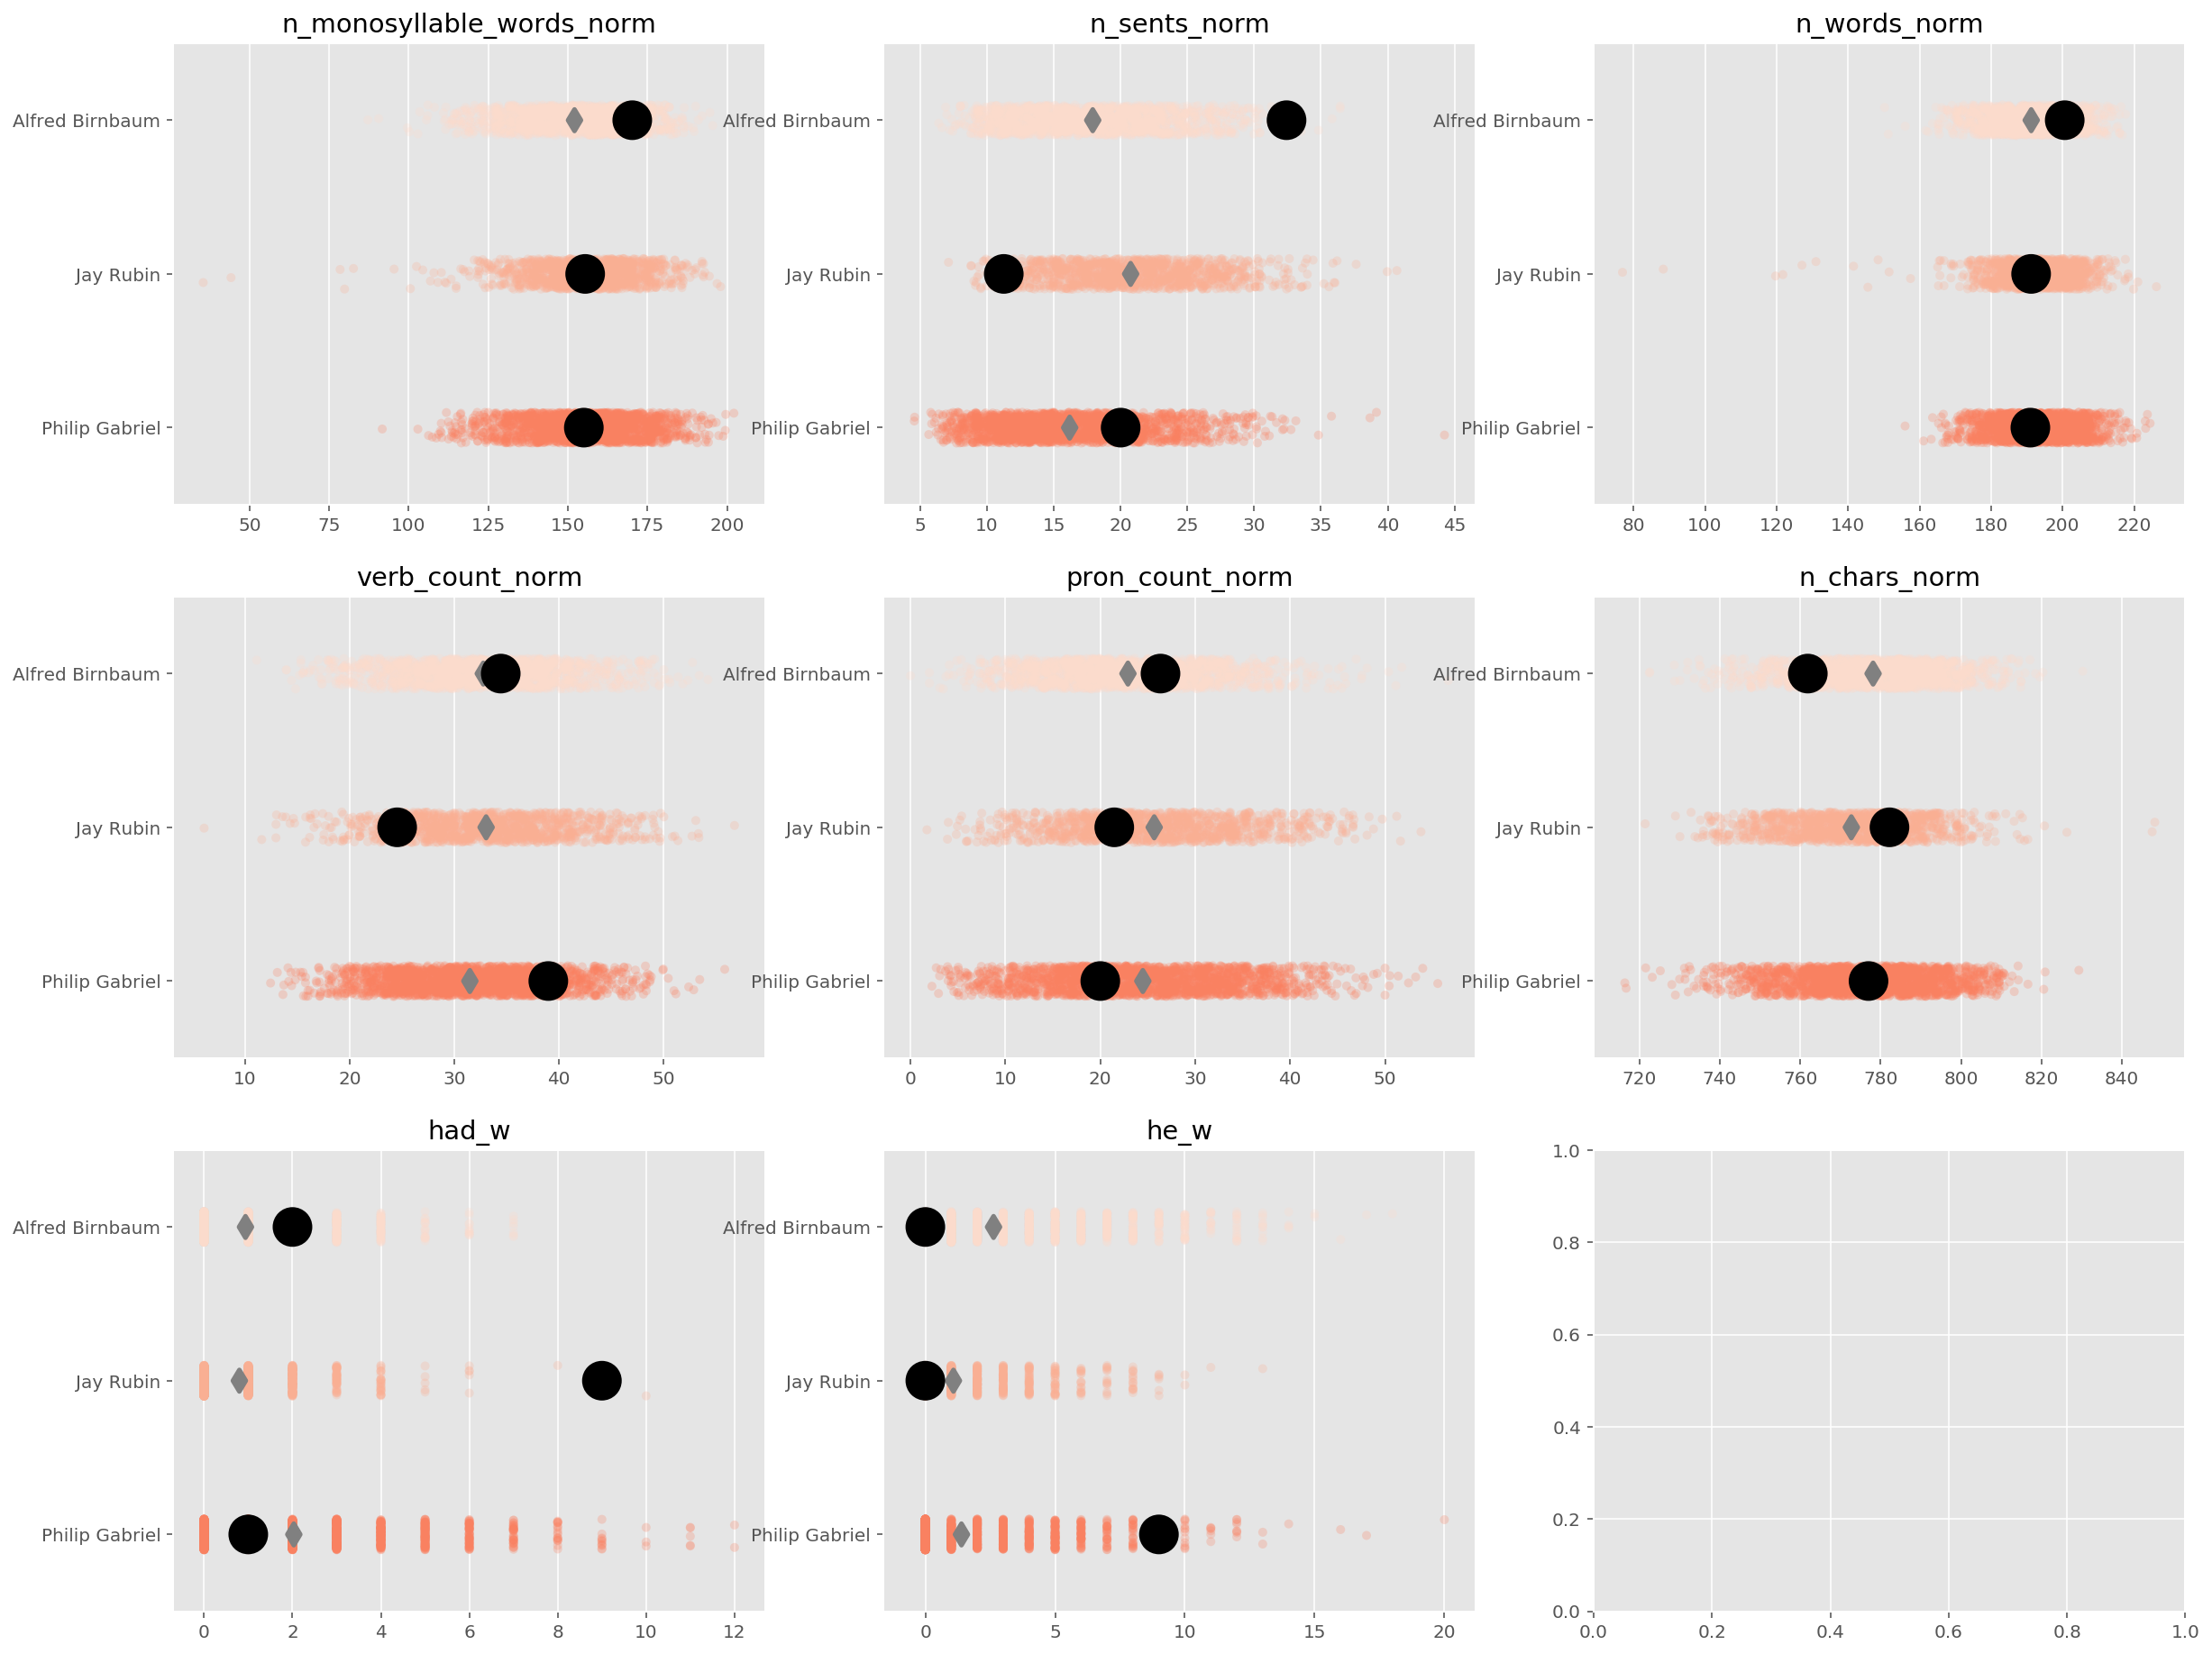

In [71]:
sns.set_palette("Reds")
preds2plot = ['n_monosyllable_words_norm',
              'n_sents_norm',
              'n_words_norm',
              'verb_count_norm',
              'pron_count_norm',
              'n_chars_norm',
              'had_w',
              'he_w']
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(20, 16), sharex=False)

for i in range(len(preds2plot)):
    sns.stripplot(x=preds2plot[i], y='translator',
                  data=df, dodge=True, alpha=.25, zorder=1, ax=ax[int(i/3),i%3])
    # Show the conditional means
    sns.pointplot(x=preds2plot[i], y='translator',
                  data=df, dodge=.532, join=False, color='grey',
                  markers="d", scale=1.25, ci=None, ax=ax[int(i/3),i%3])

    # Show the individual values for most confident predictions
    sns.pointplot(x=preds2plot[i], y="translator",
                  data=top_predictions, dodge=.532, join=False, color='black',
                  markers="o", scale=2.5, ci=None, ax=ax[int(i/3),i%3])
    ax[int(i/3),i%3].set_title(preds2plot[i])
    ax[int(i/3),i%3].set_xlabel('')
    ax[int(i/3),i%3].set_ylabel('')

# plt.subplots_adjust(hspace=0.6)
plt.show()

In [50]:
# Colourise - colours text in shell. Returns plain if colour doesn't exist.
def colourise(colour, text):
    if colour == "black":
        return "\033[1;30m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;31m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;32m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;33m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;34m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;35m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;36m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;37m" + str(text) + "\033[1;m"
    return str(text)

# Highlight - highlights text in shell. Returns plain if colour doesn't exist.
def highlight(colour, text):
    if colour == "black":
        return "\033[1;40m" + str(text) + "\033[1;m"
    if colour == "red":
        return "\033[1;41m" + str(text) + "\033[1;m"
    if colour == "green":
        return "\033[1;42m" + str(text) + "\033[1;m"
    if colour == "yellow":
        return "\033[1;43m" + str(text) + "\033[1;m"
    if colour == "blue":
        return "\033[1;44m" + str(text) + "\033[1;m"
    if colour == "magenta":
        return "\033[1;45m" + str(text) + "\033[1;m"
    if colour == "cyan":
        return "\033[1;46m" + str(text) + "\033[1;m"
    if colour == "gray":
        return "\033[1;47m" + str(text) + "\033[1;m"
    return str(text)

# # Example usage:
# print(colourise("black", "Black"))
# print(colourise("red", "Red"))
# print(colourise("green", "Green"))
# print(colourise("yellow", "Yellow"))
# print(colourise("blue", "Blue"))
# print(colourise("magenta", "Magenta"))
# print(colourise("cyan", "Cyan"))
# print(colourise("gray", "Gray"))
# print(highlight("black", "Highlight: black"))
# print(highlight("red", "Highlight: red"))
# print(highlight("green", "Highlight: green"))
# print(highlight("yellow", "Highlight: yellow"))
# print(highlight("blue", "Highlight: blue"))
# print(highlight("magenta", "Highlight: magenta"))
# print(highlight("cyan", "Highlight: cyan"))
# print(highlight("gray", "Highlight: gray"))

# Example usage of colourise() + highlight()
# text = "Blue on red is difficult to read because the wavelengths are \
# refracted onto different areas of the eye."

# print(highlight("red", (colourise("blue", text))))


In [51]:
for i in range(len(top_predictions)):
    text = top_predictions['chunks'].iloc[i]
    parsed = top_predictions['parsed'].iloc[i]
    verbs = [str(token) for token in parsed if token.pos_ == 'VERB' ]
    pronouns = [str(token) for token in parsed if token.pos_ == 'PRON' ]
    fin_list = []
    verb_count = 0
    pronoun_count = 0
    stop_count = 0
    for word in text.split():
        if word in verbs:
            fin_list.append(colourise("red", word))
            verb_count += 1
        elif word in pronouns:
            fin_list.append(colourise("magenta", word))
            pronoun_count += 1
        elif word == 'had':
            fin_list.append(colourise("green", word))
        elif word == 'he':
            fin_list.append(highlight("yellow", word))
        elif '.' in word:
            fin_list.append(highlight("cyan", word[-1]))
            stop_count += 1
        else:
            fin_list.append(word)

    print('\n')
    print(top_predictions['translator'].iloc[i])
#     print(highlight("red",verb_count))
    print(colourise("red",'verbs'), verb_count, '   ', 
          colourise("magenta",'pronouns'), pronoun_count, '   ', 
          highlight("cyan",'stops'), stop_count,)
    print('\n')
    print(' '.join(fin_list))
    



Alfred Birnbaum
verbs 22     pronouns 22     stops 24


No matter how out of focus the picture, I had to unravel each strand . Unravel, then bind all . I had to recover my . But where to begin? Not a . I was flat against a high . Everything was . No place for the hand, no place to reach out and . I was at wit’s . I paid my bill and . Big flakes of snow tumbled down from the . It wasn’t really coming down yet, but the sound of the town was different because of the . I walked briskly around the block to sober . Where to begin? Where to go? I didn’t . I was rusting, . Alone like this, I would gradually render myself . Great, just . Where to begin? My receptionist friend? She seemed . I did like . I did feel a bond between . I could sleep with her if I . But then what? Where would I go from there? Nowhere, . Just another thing to . I don’t know what I want . And, if that’s the case, as my ex-wife said, I’d only hurt .


Jay Rubin
verbs 20     pronouns 18     stops 10


I looked around, a